In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.optimize import curve_fit
from astropy import constants as const
import warnings
from scipy.stats import bootstrap
import scipy
from scipy import interpolate
import math
warnings.filterwarnings("ignore")
import matplotlib.colors as mcolors
from scipy.stats import skewnorm
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import KMeans


In [183]:
dataLI = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\STPM_improved_210721.csv",delimiter=",")
dataEA = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\test.csv",delimiter=",")
planet_name_LI        = list(dataLI["Star"]+" "+dataLI["Planet"])
dataLI["planet_name"] = planet_name_LI

earth_like_rocky  = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Mass_Radius_Curves\Earth-like Rocky (32.5% Fe+67.5% MgSiO3).txt",delimiter = "\t")
pure_rock         = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Mass_Radius_Curves\pure-Rock (100% MgSiO3).txt",delimiter = "\t")
H20_50_300K       = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Mass_Radius_Curves\50% H2O (50% Earth-like rocky core + 50% H2O layer by mass)_300 K_1mili-bar surface temprture.txt",delimiter = "\t")
H20_50_500K       = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Mass_Radius_Curves\50% H2O (50% Earth-like rocky core + 50% H2O layer by mass)_500 K_1mili-bar surface temprture.txt",delimiter = "\t")
H20_50_700K       = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Mass_Radius_Curves\50% H2O (50% Earth-like rocky core + 50% H2O layer by mass)_700 K_1mili-bar surface temprture.txt",delimiter = "\t")

earth_Mass = const.M_earth.value*1000 #g
earth_Radius = const.R_earth.value*100
earth_Volume = 4/3 * math.pi * earth_Radius**3
earth_density = earth_Mass / earth_Volume

In [184]:
# Luque Impoved
planet_id_LI         = dataLI.ID
star_name_LI         = dataLI.Star
planet_letter_LI     = dataLI.Planet

radius_LI            = dataLI.R_Rterra            # [Earth Radius]
radius_unc_up_LI     = dataLI.euR_Rterra          # [Earth Radius] Upper Unc.
radius_unc_low_LI    = dataLI.edR_Rterra          # [Earth Radius] Lower Unc.

mass_LI              = dataLI.M_Mterra            # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]
mass_unc_up_LI       = dataLI.euM_Mterra          # [Earth Mass] Upper Unc.
mass_unc_low_LI      = dataLI.edM_Mterra          # [Earth Mass] Lower Unc.

density_LI           = dataLI[dataLI.columns[32]]  # [g/cm**3]
density_unc_up_LI    = dataLI[dataLI.columns[33]]  # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_LI   = dataLI[dataLI.columns[34]]  # [g/cm**3] Planet Density Lower Unc
star_eff_LI          = dataLI.Teff_K
pl_eq_LI             = dataLI.Teq_K                # [K] Equilibrium Temperature

# Exoplanet Archive
planet_name_EA       = dataEA.pl_name
planet_id_EA         = list(range(0,len(planet_name_EA)))

radius_EA            = dataEA.pl_rade            # [Earth Radius]
period_EA            = dataEA.pl_orbper          # [days]
radius_unc_up_EA     = dataEA.pl_radeerr1        # [Earth Radius] Upper Unc.
radius_unc_low_EA    = dataEA.pl_radeerr2        # [Earth Radius] Lower Unc.
mass_EA              = dataEA.pl_bmasse          # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]

mass_unc_up_EA       = dataEA.pl_bmasseerr1      # [Earth Mass] Upper Unc.
mass_unc_low_EA      = dataEA.pl_bmasseerr2      # [Earth Mass] Lower Unc.

density_EA           = dataEA.pl_dens            # [g/cm**3]
density_unc_up_EA    = dataEA.pl_denserr1        # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_EA   = dataEA.pl_denserr2        # [g/cm**3] Planet Density Lower Unc. 
st_spectype_EA       = dataEA.st_spectype        # Spectral type of star
pl_eq_EA             = dataEA.pl_eqt             # [K] Equilibrium Temperature
st_eff_EA            = dataEA.st_teff            # Star effective temprature
st_eff_up_EA         = dataEA.st_tefferr1        # Star upper err effective temprature
st_eff_low_EA        = dataEA.st_tefferr2        # Star lower err effective temprature
disc_year_EA         = dataEA.disc_year

In [185]:
planets = ["K2-146 b",'TRAPPIST-1 h', 'TRAPPIST-1 d', 'TRAPPIST-1 e', 'TRAPPIST-1 f', 'TRAPPIST-1 g', 'TRAPPIST-1 c', 'TRAPPIST-1 b', 'GJ 1132 b', 'TOI-270 b', 'GJ 3053 c', 'GJ 1252 b', 'GJ 357 b', 'LTT 3780 b', 'LHS 1478 b', 'GJ 486 b', 'GJ 3473 b', 'CD-60 8051 b', 'L 98-59 c', 'L 98-59 d', 'GJ 3053 b', 'TOI-270 d', 'TOI-776 b', 'TOI-1634 b', 'TOI-1685 b', 'TOI-1235 b', 'K2-146 c', 'LTT 3780 c', 'TOI-270 c', 'K2-18 b', 'TOI-269 b', 'GJ 1214 b', 'K2-25 b', 'TOI-1231 b']

mass_LIV34 = []; radius_LIV34 = []; density_LIV34 = []
mass_LIV34_up    = []; mass_LIV34_low    = []; 
radius_LIV34_up  = []; radius_LIV34_low  = []; 
density_LIV34_up = []; density_LIV34_low = []; 
planet_eq_LIV34  = []
for i in range(0,len(planet_name_LI)):
    if planet_name_LI[i] in planets:
        mass_LIV34.append(mass_LI[i]); radius_LIV34.append(radius_LI[i]);density_LIV34.append(density_LI[i]);
        mass_LIV34_up.append(mass_unc_up_LI[i]);       mass_LIV34_low.append(mass_unc_low_LI[i])
        radius_LIV34_up.append(radius_unc_up_LI[i]);   radius_LIV34_low.append(radius_unc_low_LI[i])
        density_LIV34_up.append(density_unc_up_LI[i]); density_LIV34_low.append(density_unc_low_LI[i])
        planet_eq_LIV34.append(pl_eq_LI[i])

In [186]:
planet2      = []; spectype2 = []
for i in range(0,len(planet_name_EA)):
    if radius_EA[i]<4:
        if "M" in str(st_spectype_EA[i]) or st_eff_EA[i] < 3997:
            if ((mass_unc_up_EA[i] + mass_unc_up_EA[i])*0.5) / mass_EA[i] < 0.25 and math.isnan(density_unc_low_EA[i]) == False:
                if planet_name_EA[i] not in planet_name_LI:
                    planet2.append(planet_name_EA[i]); spectype2.append(st_spectype_EA[i])

In [221]:
planet2      = []; planet_i2       = []; planet_eq2   = []
disc_year2   = []; st_eff2         = []; spectype2    = []
radius2      = []; radius_up2      = []; radius_low2  = []
mass2        = []; mass_up2        = []; mass_low2    = []
density2     = []; density_up2     = []; density_low2 = []
other_names = ['LHS 1140 c' ,'L 168-9 b', 'L 168-9 c']

for i in range(0,len(planet_name_EA)):
    if ((radius_unc_up_EA[i] + radius_unc_up_EA[i])*0.5) / radius_EA[i] < 0.1 and radius_EA[i]<4:
        if radius_EA[i]<4:
            if "M" in str(st_spectype_EA[i]):
                if ((mass_unc_up_EA[i] + mass_unc_up_EA[i])*0.5) / mass_EA[i] < 0.25 and math.isnan(density_unc_low_EA[i]) == False:
                    if planet_name_EA[i] not in planet_name_LI and planet_name_EA[i] not in other_names:
                        st_eff2.append(st_eff_EA[i]); spectype2.append(st_spectype_EA[i])
                        planet_eq2.append(pl_eq_EA[i]); planet2.append(planet_name_EA[i]); disc_year2.append(disc_year_EA[i])
                        radius2.append(dataEA.pl_rade[i]); radius_up2.append(dataEA.pl_radeerr1[i]); radius_low2.append(dataEA.pl_radeerr2[i])
                        density2.append(dataEA.pl_dens[i]); density_up2.append(dataEA.pl_denserr1[i]); density_low2.append(dataEA.pl_denserr2[i])
                        mass2.append(dataEA.pl_bmasse[i]); mass_up2.append(dataEA.pl_bmasseerr1[i]);  mass_low2.append(dataEA.pl_bmasseerr2[i])


In [222]:
for i in range(0,len(st_eff2)::
    print(str(spectype2[i])+"    "+str(st_eff2[i]))

M2 V    3556.0
M1.0 V    3522.0
M1.0 V    3522.0
M1.5 V    3600.0
M0 V    3803.0
M0 V    3803.0
K9 V/M0 V    3875.0
M2.0 V    3476.0
M1.5 V    3709.0
M1 V    3690.0
M0.0 V    4065.0
M2.5 V    3433.0


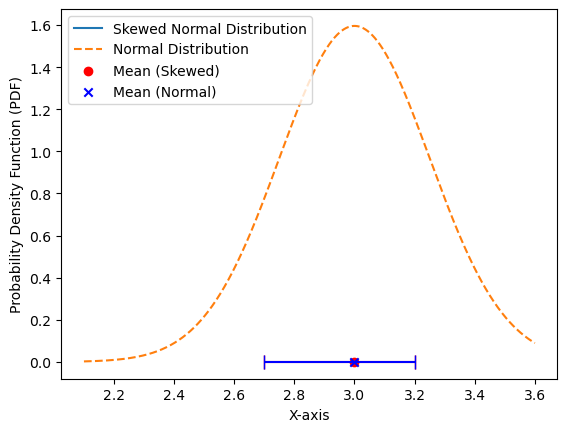

In [335]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm, norm

# Given data
x_mean = 3
error_x_up = 0.2
error_x_down = 0.3

# Generate x values
x_values = np.linspace(x_mean - 3 * error_x_down, x_mean + 3 * error_x_up, 1000)

# Calculate the probability density function (PDF) of the skewed normal distribution
pdf_skewed = skewnorm.pdf(x_values, a=5, loc=x_mean, scale=(error_x_up - error_x_down) / 2)

# Calculate the PDF of the normal distribution
pdf_normal = norm.pdf(x_values, loc=x_mean, scale=(error_x_up + error_x_down) / 2)

# Plot the skewed normal distribution
plt.plot(x_values, pdf_skewed, label='Skewed Normal Distribution')

# Plot the normal distribution
plt.plot(x_values, pdf_normal, label='Normal Distribution', linestyle='dashed')

# Plot mean and error bars for the skewed normal distribution
plt.scatter(x_mean, 0, color='red', marker='o', label='Mean (Skewed)')
plt.errorbar(x_mean, 0, xerr=[[error_x_down], [error_x_up]], fmt='none', color='red', capsize=5)

# Plot mean and error bars for the normal distribution
plt.scatter(x_mean, 0, color='blue', marker='x', label='Mean (Normal)')
plt.errorbar(x_mean, 0, xerr=[[error_x_down], [error_x_up]], fmt='none', color='blue', capsize=5)

# Set axis labels
plt.xlabel('X-axis')
plt.ylabel('Probability Density Function (PDF)')

# Add legend
plt.legend()

# Show the plot
plt.show()


(0.0, 10.0)

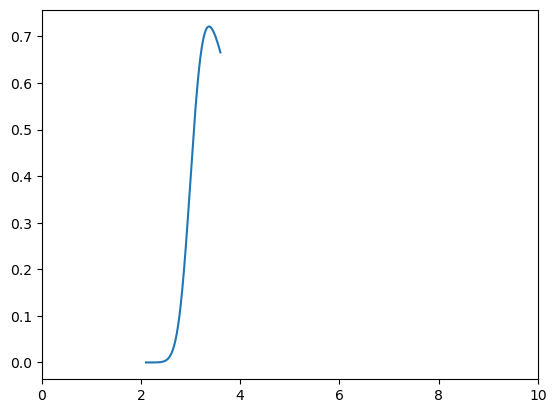

In [342]:
plt.plot(x_values, pdf_skewed, label='Skewed Normal Distribution')
plt.xlim(0,10)

In [223]:
earth_like_rocky_mass_g        = earth_Mass*np.array(earth_like_rocky["Mass"])
earth_like_rocky_radius_cm     = earth_Radius*np.array(earth_like_rocky["Radius"])
earth_like_rocky_density_g_cm3 = (earth_like_rocky_mass_g) / ((4/3)*(np.pi)*(np.power(earth_like_rocky_radius_cm,3))   ) 

H20_50_500K_mass_g        = earth_Mass*np.array(H20_50_500K["Mass"])
H20_50_500K_radius_cm     = earth_Radius*np.array(H20_50_500K["Radius"])
H20_50_500K_density_g_cm3 = (H20_50_500K_mass_g) / ((4/3)*(np.pi)*(np.power(H20_50_500K_radius_cm,3))   ) 

def rocky_density(mass):
    x_points  = earth_like_rocky["Mass"]
    y_points  = earth_like_rocky_density_g_cm3
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

def rocky_density2(mass):
    x_points  = earth_like_rocky["Mass"]
    y_points  = earth_like_rocky_density_g_cm3/earth_like_rocky_density_g_cm3
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()




In [227]:
mass = np.concatenate((mass2,mass_LIV34))
density = np.concatenate((np.array(density2)/ rocky_density(mass2),np.array(density_LIV34)/rocky_density(mass_LIV34)))
radius  = np.concatenate((radius2,radius_LIV34))
planet  = np.concatenate((planet2,planets))
pl_eq   = np.concatenate((planet_eq2,planet_eq_LIV34))
mass_up    = np.concatenate((mass_up2,mass_LIV34_up));       mass_low    = np.concatenate((mass_low2,mass_LIV34_low))
radius_up  = np.concatenate((radius_up2,radius_LIV34_up));   radius_low  = np.concatenate((radius_low2,radius_LIV34_low))
density_up = np.concatenate((np.array(density_up2)/ rocky_density(mass2),np.array(density_LIV34_up)/ rocky_density(mass_LIV34))); density_low = np.concatenate((np.array(density_low2)/ rocky_density(mass2),np.array(density_LIV34_low)/ rocky_density(mass_LIV34)))

mass_error    = [np.abs(mass_low),mass_up]
radius_error  = [np.abs(radius_low),radius_up]
density_error = [np.abs(density_low),density_up]

IndexError: index 46 is out of bounds for axis 0 with size 46

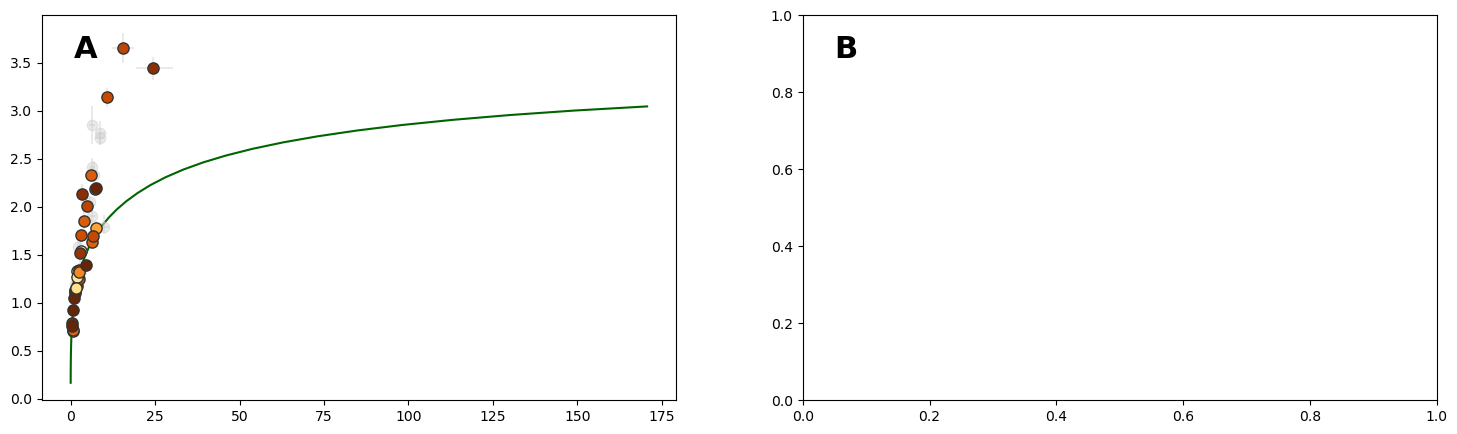

In [228]:
fig, ax = plt.subplots(figsize=(18,5))
for i, label in enumerate(('A', 'B')):
    ax = fig.add_subplot(1,2,i+1)
    ax.text(0.05, 0.95, label, transform=ax.transAxes,
      fontsize=22, fontweight='bold', va='top')
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
planets = ["K2-146 b",'TRAPPIST-1 h', 'TRAPPIST-1 d', 'TRAPPIST-1 e', 'TRAPPIST-1 f', 'TRAPPIST-1 g', 'TRAPPIST-1 c', 'TRAPPIST-1 b', 'GJ 1132 b', 'TOI-270 b', 'GJ 3053 c', 'GJ 1252 b', 'GJ 357 b', 'LTT 3780 b', 'LHS 1478 b', 'GJ 486 b', 'GJ 3473 b', 'CD-60 8051 b', 'L 98-59 c', 'L 98-59 d', 'GJ 3053 b', 'TOI-270 d', 'TOI-776 b', 'TOI-1634 b', 'TOI-1685 b', 'TOI-1235 b', 'K2-146 c', 'LTT 3780 c', 'TOI-270 c', 'K2-18 b', 'TOI-269 b', 'GJ 1214 b', 'K2-25 b', 'TOI-1231 b']
plt.errorbar(mass,radius,xerr = mass_error, yerr=radius_error,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
# plt.scatter(mass_LI[i], radius_LI[i], s=72, facecolors='none', edgecolors='0.2')

plt.plot(list(earth_like_rocky["Mass"]),list(earth_like_rocky["Radius"]),"-",color = "Darkgreen",label = "50% H2O",zorder = -40)

norm = mcolors.Normalize(vmin=300, vmax=1200)  # Set the desired min and max values
cmap = plt.cm.get_cmap('YlOrBr_r')
for i in range(0,len(planet_name_LI)):
    if planet_name_LI[i] in planets:
        plt.scatter(mass[i], radius[i],c=[pl_eq_LI[i]], cmap=cmap, norm=norm, marker='o',s=65, edgecolors='0.2')   
plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.ylabel("$Radius\ [R_{\oplus}]$")
plt.xscale("log"); plt.xlim(0.1,30); plt.ylim(0.5,4)
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
leg = plt.legend(loc = 1)
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.title("2024 Sample")

plt.subplot(1, 2, 2)  # 1 row, 2 columns, first subplot
plt.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3 / rocky_density(earth_like_rocky["Mass"]), "-", color="darkgreen", label="Earth-Like", zorder=-32)
plt.errorbar(mass,density,xerr = mass_error, yerr=density_error,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
for i in range(0,len(planet_name_LI)):
    if planet_name_LI[i] in planets:
        plt.scatter(mass[i], density[i],c=[pl_eq_LI[i]], cmap=cmap, norm=norm, marker='o',s=65, edgecolors='0.2')   
cbar = plt.colorbar(label = "Equilibrium Temperature  [K]")
plt.xlabel("Mass $[M_{\oplus}]$")
plt.ylabel("Density $[ρ/ρ_{\oplus model}]$")
plt.xscale("log"); plt.xlim(0.1,30); plt.ylim(0,2.5)
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
plt.title("2024 Sample")
leg = plt.legend(loc = 1)
for line in leg.get_lines():
    line.set_linewidth(8.0)
image_name = '2024sample1.jpeg'
image_format = 'jpeg'
fig.savefig(image_name, format=image_format, dpi=800)

In [229]:
mass10_error    = [np.log10(mass + np.abs(mass_low)) - np.log10(mass),np.log10(mass + np.abs(mass_up)) - np.log10(mass)]

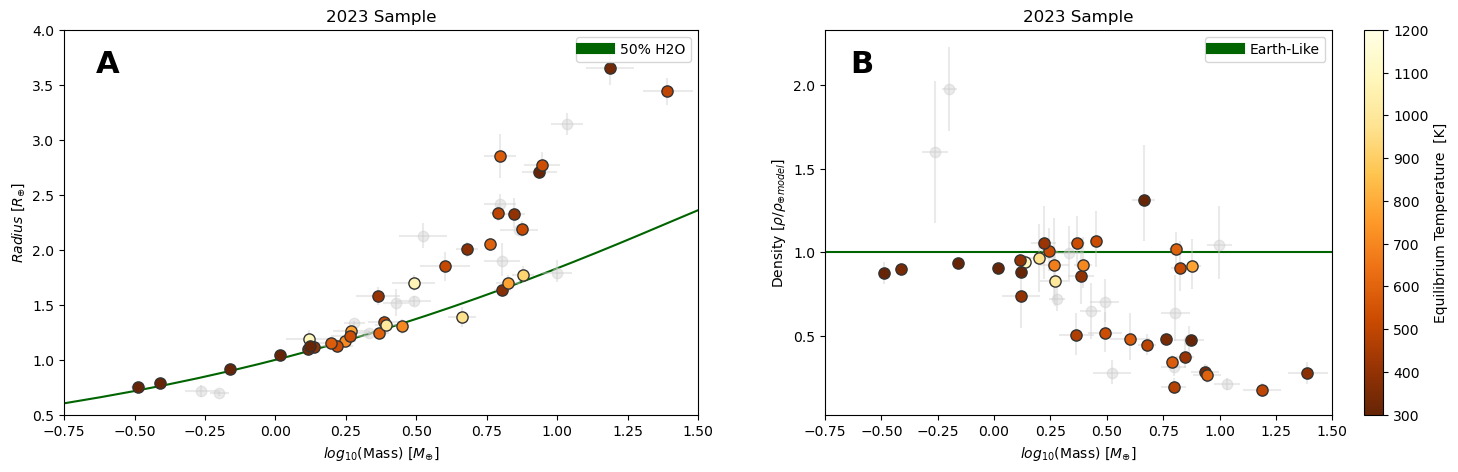

In [233]:
fig, ax = plt.subplots(figsize=(18,5))
for i, label in enumerate(('A', 'B')):
    ax = fig.add_subplot(1,2,i+1)
    ax.text(0.05, 0.95, label, transform=ax.transAxes,
      fontsize=22, fontweight='bold', va='top')
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
planets = ["K2-146 b",'TRAPPIST-1 h', 'TRAPPIST-1 d', 'TRAPPIST-1 e', 'TRAPPIST-1 f', 'TRAPPIST-1 g', 'TRAPPIST-1 c', 'TRAPPIST-1 b', 'GJ 1132 b', 'TOI-270 b', 'GJ 3053 c', 'GJ 1252 b', 'GJ 357 b', 'LTT 3780 b', 'LHS 1478 b', 'GJ 486 b', 'GJ 3473 b', 'CD-60 8051 b', 'L 98-59 c', 'L 98-59 d', 'GJ 3053 b', 'TOI-270 d', 'TOI-776 b', 'TOI-1634 b', 'TOI-1685 b', 'TOI-1235 b', 'K2-146 c', 'LTT 3780 c', 'TOI-270 c', 'K2-18 b', 'TOI-269 b', 'GJ 1214 b', 'K2-25 b', 'TOI-1231 b']
plt.errorbar(np.log10(mass),radius,xerr = mass10_error, yerr=radius_error,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
# plt.scatter(mass_LI[i], radius_LI[i], s=72, facecolors='none', edgecolors='0.2')

plt.plot(list(np.log10(earth_like_rocky["Mass"])),list(earth_like_rocky["Radius"]),"-",color = "Darkgreen",label = "50% H2O",zorder = -40)

norm = mcolors.Normalize(vmin=300, vmax=1200)  # Set the desired min and max values
cmap = plt.cm.get_cmap('YlOrBr_r')
for i in range(0,len(planet)):
    if planet[i] in planets:
        plt.scatter(np.log10(mass[i]), radius[i],c=[pl_eq[i]], cmap=cmap, norm=norm, marker='o',s=65, edgecolors='0.2')   
plt.xlabel("$log_{10}$(Mass) $[M_{\oplus}]$")
plt.ylabel("$Radius\ [R_{\oplus}]$")
plt.xlim(-0.75,1.5); plt.ylim(0.5,4)
leg = plt.legend(loc = 1)
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.title("2023 Sample")

plt.subplot(1, 2, 2)  # 1 row, 2 columns, first subplot
plt.plot(np.log10(earth_like_rocky["Mass"]), earth_like_rocky_density_g_cm3 / rocky_density(earth_like_rocky["Mass"]), "-", color="darkgreen", label="Earth-Like", zorder=-32)
plt.errorbar(np.log10(mass),density,xerr = mass10_error, yerr=density_error,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
for i in range(0,len(planet)):
    if planet[i] in planets:
        plt.scatter(np.log10(mass[i]), density[i],c=[pl_eq_LI[i]], cmap=cmap, norm=norm, marker='o',s=65, edgecolors='0.2')   
cbar = plt.colorbar(label = "Equilibrium Temperature  [K]")
plt.xlabel("$log_{10}$(Mass) $[M_{\oplus}]$")
plt.ylabel("Density $[ρ/ρ_{\oplus model}]$")
plt.title("2023 Sample")
plt.xlim(-0.75,1.5)
leg = plt.legend(loc = 1)
for line in leg.get_lines():
    line.set_linewidth(8.0)
image_name = '2023sample1.jpeg'
image_format = 'jpeg'
#fig.savefig(image_name, format=image_format, dpi=800)

Text(0.5, 1.0, 'DBSCAN on 2023 Sample')

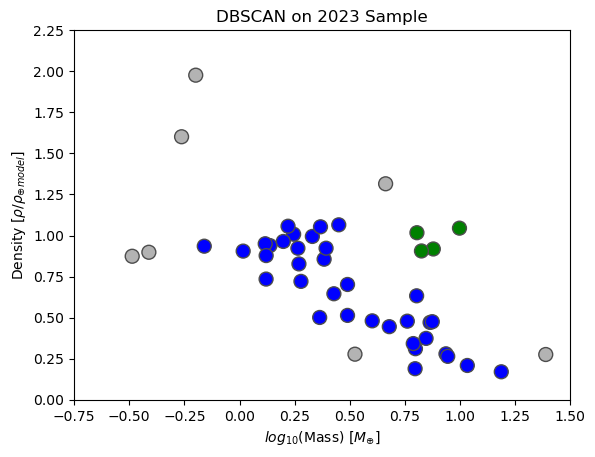

In [235]:
def colorlist(labels):
    color=["0.7",'blue', 'green',"red","yellow"]
    colors = []
    for i in range(len(labels)):
        if labels[i] == -1:
            colors.append(color[0])
        if labels[i] == 0:
            colors.append(color[1])
        if labels[i] == 1:
            colors.append(color[2])
        if labels[i] == 2:
            colors.append(color[3])
        if labels[i] == 3:
            colors.append(color[4])
    return colors

df = pd.DataFrame({'Mass': np.log10(mass), 'Density': density})
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
esps = 0.2
dbscan = DBSCAN(eps=esps, min_samples=4,metric = "euclidean")
dbscan.fit(df)
clusters = dbscan.fit_predict(df)
colors = colorlist(clusters)
plt.scatter(np.log10(mass) ,density, c=colors, s=100, edgecolor="0.3")
plt.xlim(-0.75,1.5), plt.ylim(0,2.25)

plt.xlabel("$log_{10}$(Mass) $[M_{\oplus}]$")
plt.ylabel("Density $[ρ/ρ_{\oplus model}]$")
plt.title("DBSCAN on 2023 Sample")



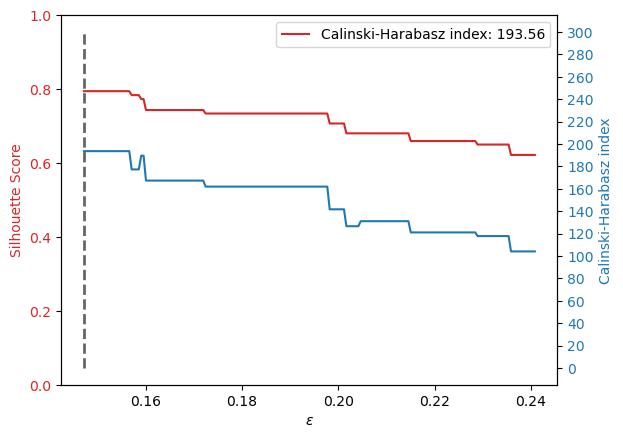

Text(0.5, 1.0, 'DBSCAN on 2024 Sample')

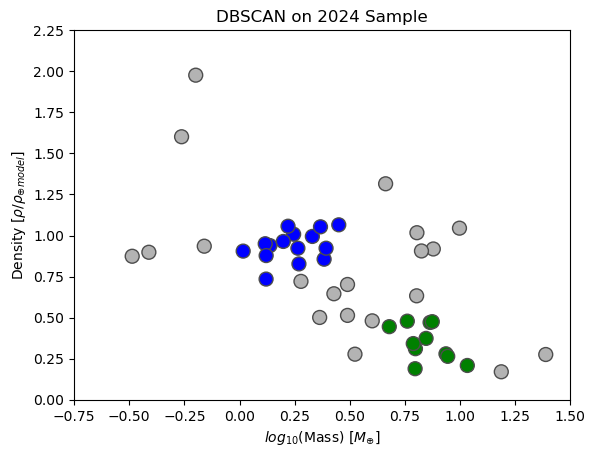

In [245]:
esps = np.linspace(0.01,1, 2000)
ax = plt.subplot(1, 1, 1)

epsilons = []
silhouette_avg = []
calinski_harabasz_index = []

for i in range(0,len(esps)):
    dbscan = DBSCAN(eps=esps[i], min_samples=8,metric = "euclidean")
    dbscan.fit(df)
    clusters = dbscan.fit_predict(df)
    if 1 in clusters:
        silhouette_avg.append(silhouette_score(df[clusters != -1], clusters[clusters != -1]))
        calinski_harabasz_index.append(calinski_harabasz_score(df[clusters != -1], clusters[clusters != -1]))
        epsilons.append(esps[i]) 

ax1 = ax
ax2 = ax.twinx()
color = 'tab:red'
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(epsilons, silhouette_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1])

color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz index', color=color)
ax2.plot(epsilons, calinski_harabasz_index, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.yticks([0,20,40,60,80,100,120,140,160,180,200,220,240,260,280,300])

max_value = max(calinski_harabasz_index)
max_index = calinski_harabasz_index.index(max_value)

fig.tight_layout()
plt.vlines(epsilons[max_index],0,300,colors = "0.4",linestyle = "dashed",zorder=-32,linewidth = 2)
ax1.legend(["Silhouette Score:             " + str(np.round(silhouette_avg[max_index],2))])
ax1.legend(["Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[max_index],2))])
plt.show()

df = pd.DataFrame({'Mass': np.log10(mass), 'Density': density})
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
esps = epsilons[max_index]

dbscan = DBSCAN(eps=esps, min_samples=5,metric = "euclidean")
dbscan.fit(df)
clusters = dbscan.fit_predict(df)
colors = colorlist(clusters)
plt.scatter(np.log10(mass) ,density, c=colors, s=100, edgecolor="0.3")
plt.xlim(-0.75,1.5), plt.ylim(0,2.25)
plt.xlabel("$log_{10}$(Mass) $[M_{\oplus}]$")
plt.ylabel("Density $[ρ/ρ_{\oplus model}]$")
plt.title("DBSCAN on 2024 Sample")


DBSCAN: min_samples = 4, ε = 0.32
Silhouette Score:        0.77
Calinski-Harabasz index: 196.68

DBSCAN: min_samples = 5, ε = 0.40
Silhouette Score:        0.77
Calinski-Harabasz index: 197.16

DBSCAN: min_samples = 6, ε = 0.43
Silhouette Score:        0.78
Calinski-Harabasz index: 175.14

DBSCAN: min_samples = 7, ε = 0.45
Silhouette Score:        0.79
Calinski-Harabasz index: 171.49

DBSCAN: min_samples = 8, ε = 0.49
Silhouette Score:        0.79
Calinski-Harabasz index: 197.46

DBSCAN: min_samples = 9, ε = 0.605
Silhouette Score:        0.79
Calinski-Harabasz index: 197.46



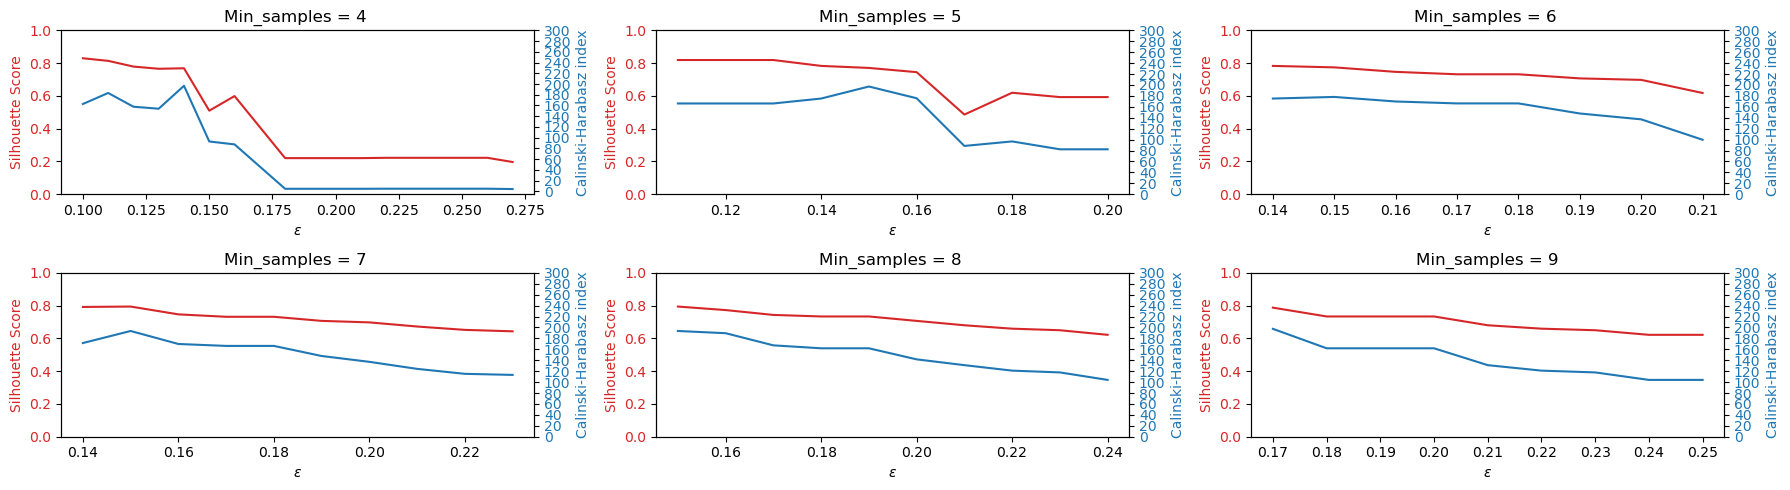

In [240]:
fig, ax = plt.subplots(figsize=(18,5))
df = pd.DataFrame({'Mass': np.log10(mass), 'Density': density})
esps = np.linspace(0.01,1, 100)

####  MIN_SAMPLE = 4 #####
epsilons = []
silhouette_avg = []
calinski_harabasz_index = []

for i in range(0,len(esps)):
    dbscan = DBSCAN(eps=esps[i], min_samples=4,metric = "euclidean")
    dbscan.fit(df)
    clusters = dbscan.fit_predict(df)
    if 1 in clusters:
        silhouette_avg.append(silhouette_score(df[clusters != -1], clusters[clusters != -1]))
        calinski_harabasz_index.append(calinski_harabasz_score(df[clusters != -1], clusters[clusters != -1]))
        epsilons.append(esps[i]) 
        
ax = plt.subplot(2, 3, 1)
ax1 = ax
ax2 = ax.twinx()
plt.title("Min_samples = 4 ")
color = 'tab:red'
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(epsilons, silhouette_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz index', color=color)
ax2.plot(epsilons, calinski_harabasz_index, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax2.set_yticks([0,20,40,60,80,100,120,140,160,180,200,220,240,260,280,300])
fig.tight_layout()

max_value = max(calinski_harabasz_index)
max_index = calinski_harabasz_index.index(max_value)
print("DBSCAN: min_samples = 4, ε = 0.32")
print("Silhouette Score:        " + str(np.round(silhouette_avg[max_index],2)))
print("Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[max_index],2)))
print("")

####  MIN_SAMPLE = 5 #####
epsilons = []
silhouette_avg = []
calinski_harabasz_index = []

for i in range(0,len(esps)):
    dbscan = DBSCAN(eps=esps[i], min_samples=5,metric = "euclidean")
    dbscan.fit(df)
    clusters = dbscan.fit_predict(df)
    if 1 in clusters:
        silhouette_avg.append(silhouette_score(df[clusters != -1], clusters[clusters != -1]))
        calinski_harabasz_index.append(calinski_harabasz_score(df[clusters != -1], clusters[clusters != -1]))
        epsilons.append(esps[i]) 

ax = plt.subplot(2, 3, 2)
ax1 = ax
ax2 = ax.twinx()
plt.title("Min_samples = 5 ")

color = 'tab:red'
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(epsilons, silhouette_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz index', color=color)
ax2.plot(epsilons, calinski_harabasz_index, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax2.set_yticks([0,20,40,60,80,100,120,140,160,180,200,220,240,260,280,300])
fig.tight_layout()

max_value = max(calinski_harabasz_index)
max_index = calinski_harabasz_index.index(max_value)
print("DBSCAN: min_samples = 5, ε = 0.40")
print("Silhouette Score:        " + str(np.round(silhouette_avg[max_index],2)))
print("Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[max_index],2)))
print("")

####  MIN_SAMPLE = 6 #####
epsilons = []
silhouette_avg = []
calinski_harabasz_index = []

for i in range(0,len(esps)):
    dbscan = DBSCAN(eps=esps[i], min_samples=6,metric = "euclidean")
    dbscan.fit(df)
    clusters = dbscan.fit_predict(df)
    if 1 in clusters:
        silhouette_avg.append(silhouette_score(df[clusters != -1], clusters[clusters != -1]))
        calinski_harabasz_index.append(calinski_harabasz_score(df[clusters != -1], clusters[clusters != -1]))
        epsilons.append(esps[i]) 

ax = plt.subplot(2, 3, 3)

ax1 = ax
ax2 = ax.twinx()
plt.title("Min_samples = 6 ")

color = 'tab:red'
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(epsilons, silhouette_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz index', color=color)
ax2.plot(epsilons, calinski_harabasz_index, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax2.set_yticks([0,20,40,60,80,100,120,140,160,180,200,220,240,260,280,300])

fig.tight_layout()
print("DBSCAN: min_samples = 6, ε = 0.43")
print("Silhouette Score:        " + str(np.round(silhouette_avg[0],2)))
print("Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[0],2)))
print("")

####  MIN_SAMPLE = 7 #####
epsilons = []
silhouette_avg = []
calinski_harabasz_index = []

for i in range(0,len(esps)):
    dbscan = DBSCAN(eps=esps[i], min_samples=7,metric = "euclidean")
    dbscan.fit(df)
    clusters = dbscan.fit_predict(df)
    if 1 in clusters:
        silhouette_avg.append(silhouette_score(df[clusters != -1], clusters[clusters != -1]))
        calinski_harabasz_index.append(calinski_harabasz_score(df[clusters != -1], clusters[clusters != -1]))
        epsilons.append(esps[i]) 


ax = plt.subplot(2, 3, 4)
ax1 = ax
ax2 = ax.twinx()
plt.title("Min_samples = 7 ")

color = 'tab:red'
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(epsilons, silhouette_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz index', color=color)
ax2.plot(epsilons, calinski_harabasz_index, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax2.set_yticks([0,20,40,60,80,100,120,140,160,180,200,220,240,260,280,300])
fig.tight_layout()
print("DBSCAN: min_samples = 7, ε = 0.45")
print("Silhouette Score:        " + str(np.round(silhouette_avg[0],2)))
print("Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[0],2)))
print("")


####  MIN_SAMPLE = 8 #####
epsilons = []
silhouette_avg = []
calinski_harabasz_index = []

for i in range(0,len(esps)):
    dbscan = DBSCAN(eps=esps[i], min_samples=8,metric = "euclidean")
    dbscan.fit(df)
    clusters = dbscan.fit_predict(df)
    if 1 in clusters:
        silhouette_avg.append(silhouette_score(df[clusters != -1], clusters[clusters != -1]))
        calinski_harabasz_index.append(calinski_harabasz_score(df[clusters != -1], clusters[clusters != -1]))
        epsilons.append(esps[i]) 
        

ax = plt.subplot(2, 3, 5)
ax1 = ax
ax2 = ax.twinx()
plt.title("Min_samples = 8 ")

color = 'tab:red'
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(epsilons, silhouette_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz index', color=color)
ax2.plot(epsilons, calinski_harabasz_index, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax2.set_yticks([0,20,40,60,80,100,120,140,160,180,200,220,240,260,280,300])
fig.tight_layout()

####  MIN_SAMPLE = 9 #####
epsilons = []
silhouette_avg = []
calinski_harabasz_index = []

for i in range(0,len(esps)):
    dbscan = DBSCAN(eps=esps[i], min_samples=9,metric = "euclidean")
    dbscan.fit(df)
    clusters = dbscan.fit_predict(df)
    if 1 in clusters:
        silhouette_avg.append(silhouette_score(df[clusters != -1], clusters[clusters != -1]))
        calinski_harabasz_index.append(calinski_harabasz_score(df[clusters != -1], clusters[clusters != -1]))
        epsilons.append(esps[i]) 

print("DBSCAN: min_samples = 8, ε = 0.49")
print("Silhouette Score:        " + str(np.round(silhouette_avg[0],2)))
print("Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[0],2)))
print("")

ax = plt.subplot(2, 3, 6)
ax1 = ax
ax2 = ax.twinx()
plt.title("Min_samples = 9")

color = 'tab:red'
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(epsilons, silhouette_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz index', color=color)
ax2.plot(epsilons, calinski_harabasz_index, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax2.set_yticks([0,20,40,60,80,100,120,140,160,180,200,220,240,260,280,300])

max_value = max(silhouette_avg)
max_index = silhouette_avg.index(max_value)
print("DBSCAN: min_samples = 9, ε = 0.605")
print("Silhouette Score:        " + str(np.round(silhouette_avg[max_index],2)))
print("Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[max_index],2)))
print("")

In [144]:
 max(calinski_harabasz_index)

171.87757415337447

In [ ]:
ax = plt.subplot(6, 3, 1)
plt.title("Min_samples = 4")
dbscan = DBSCAN(eps=0.35, min_samples=4,metric = "euclidean")
dbscan.fit(scaled_data)
clusters = dbscan.fit_predict(pca_result)
clusters4 = clusters
colors = colorlist(clusters)
plt.errorbar(mass,density/earth_density,xerr = mass_error,yerr = density_error/earth_density,fmt = ".",color = "0.7",zorder = -40)
ax.scatter(mass, density/earth_density, c=colors, s=100, edgecolor="0.3")
ax.set_xlim(0.1, 30)
ax.set_ylim(0,2.5)
ax.set_xlabel("Mass $[M_{\oplus}]$")
ax.set_ylabel("Density $[ρ_{\oplus}]$")

pop1 = [(density/earth_density)[i] for i in range(len(clusters)) if clusters[i] == 0]
pop2 = [(density/earth_density)[i] for i in range(len(clusters)) if clusters[i] == 1]
pop3 = [(density/earth_density)[i] for i in range(len(clusters)) if clusters[i] == -1]
ax = plt.subplot(6, 3, 2)
bins = 30
range_min = min(min(pop1), min(pop2), min(pop3))
range_max = max(max(pop1), max(pop2), max(pop3))
hbins  = np.linspace(0, range_max + 0.2, 1000)
ax.hist([pop1, pop2, pop3], bins=bins, range=(range_min, range_max), alpha=0.5, label=['pop1', 'pop2', 'Outliers'], color=['blue', 'green', "0.7"], stacked=True)
hist_values_false, bin_edges, _ = ax.hist(pop1, bins=bins,range=(range_min, range_max), color='Blue', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop1)
sigma = np.sqrt(np.cov(pop1, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Blue",linewidth=3,label ="Pop1 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

hist_values_false, bin_edges, _ = ax.hist(pop2, bins=bins,range=(range_min, range_max), color='Green', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop2)
sigma = np.sqrt(np.cov(pop2, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Green",linewidth=3,label ="Pop2 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))
plt.legend()
ax.set_xlabel("Density $[ρ_{\oplus}]$")
ax.set_ylabel("Number of Planets")

epsilons = []
silhouette_avg = []
calinski_harabasz_index = []

ax = plt.subplot(6, 3, 3)
for i in range(0,len(esps)):
    dbscan = DBSCAN(eps=esps[i], min_samples=4,metric = "euclidean")
    dbscan.fit(pca_result)
    clusters = dbscan.fit_predict(pca_result)
    if 1 in clusters:
        silhouette_avg.append(silhouette_score(pca_result[clusters != -1], clusters[clusters != -1]))
        calinski_harabasz_index.append(calinski_harabasz_score(pca_result[clusters != -1], clusters[clusters != -1]))
        epsilons.append(esps[i]) 

ax1 = ax
ax2 = ax.twinx()
color = 'tab:red'
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(epsilons, silhouette_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1])

color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz index', color=color)
ax2.plot(epsilons, calinski_harabasz_index, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.yticks([0,20,40,60,80,100])

max_value = max(silhouette_avg)
max_index = silhouette_avg.index(max_value)

fig.tight_layout()
plt.vlines(np.round(epsilons[max_index],2),0,100,colors = "0.4",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.legend(["Silhouette Score:             " + str(np.round(silhouette_avg[max_index],2)),"Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[max_index],2))])
#print("DBSCAN: min_samples = 4, ε = "+str(np.round(epsilons[max_index],2)))
#print("Silhouette Score:        " + str(np.round(silhouette_avg[max_index],2)))
#print("Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[max_index],2)))
#print("")

DBSCAN: min_samples = 4, ε = 0.32
Silhouette Score:        0.58
Calinski-Harabasz index: 52.26

DBSCAN: min_samples = 5, ε = 0.40
Silhouette Score:        0.58
Calinski-Harabasz index: 58.06

DBSCAN: min_samples = 6, ε = 0.43
Silhouette Score:        0.67
Calinski-Harabasz index: 62.43

DBSCAN: min_samples = 7, ε = 0.45
Silhouette Score:        0.63
Calinski-Harabasz index: 56.14

DBSCAN: min_samples = 8, ε = 0.49
Silhouette Score:        0.58
Calinski-Harabasz index: 59.42

DBSCAN: min_samples = 9, ε = 0.605
Silhouette Score:        0.59
Calinski-Harabasz index: 71.74



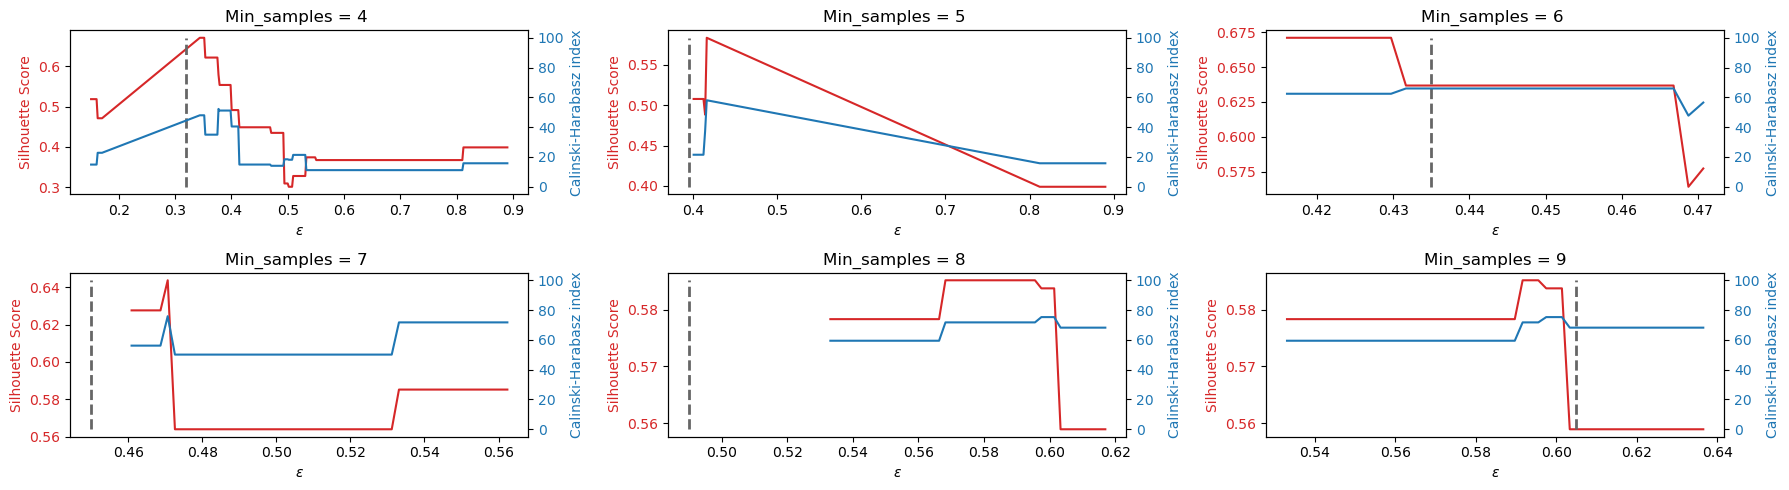

In [220]:
fig, ax = plt.subplots(figsize=(18,5))
df = pd.DataFrame({'Mass': mass, 'Density': density})

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
esps = np.linspace(0.1,4, 2000)

####  MIN_SAMPLE = 4 #####
epsilons = []
silhouette_avg = []
calinski_harabasz_index = []

for i in range(0,len(esps)):
    dbscan = DBSCAN(eps=esps[i], min_samples=4,metric = "euclidean")
    dbscan.fit(pca_result)
    clusters = dbscan.fit_predict(pca_result)
    if 1 in clusters:
        silhouette_avg.append(silhouette_score(pca_result[clusters != -1], clusters[clusters != -1]))
        calinski_harabasz_index.append(calinski_harabasz_score(pca_result[clusters != -1], clusters[clusters != -1]))
        epsilons.append(esps[i])
        
ax = plt.subplot(2, 3, 1)
ax1 = ax
ax2 = ax.twinx()
plt.title("Min_samples = 4 ")
color = 'tab:red'
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(epsilons, silhouette_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz index', color=color)
ax2.plot(epsilons, calinski_harabasz_index, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.yticks([0,20,40,60,80,100])

fig.tight_layout()
plt.vlines(0.32,0,100,colors = "0.4",linestyle = "dashed",zorder=-32,linewidth = 2)

max_value = max(calinski_harabasz_index)
max_index = calinski_harabasz_index.index(max_value)
print("DBSCAN: min_samples = 4, ε = 0.32")
print("Silhouette Score:        " + str(np.round(silhouette_avg[max_index],2)))
print("Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[max_index],2)))
print("")

####  MIN_SAMPLE = 5 #####
epsilons = []
silhouette_avg = []
calinski_harabasz_index = []

for i in range(0,len(esps)):
    dbscan = DBSCAN(eps=esps[i], min_samples=5,metric = "euclidean")
    dbscan.fit(pca_result)
    clusters = dbscan.fit_predict(pca_result)
    if 1 in clusters:
        silhouette_avg.append(silhouette_score(pca_result[clusters != -1], clusters[clusters != -1]))
        calinski_harabasz_index.append(calinski_harabasz_score(pca_result[clusters != -1], clusters[clusters != -1]))
        epsilons.append(esps[i])


ax = plt.subplot(2, 3, 2)
ax1 = ax
ax2 = ax.twinx()
plt.title("Min_samples = 5 ")
plt.vlines(0.395,0,100,colors = "0.4",linestyle = "dashed",zorder=-32,linewidth = 2)

color = 'tab:red'
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(epsilons, silhouette_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz index', color=color)
ax2.plot(epsilons, calinski_harabasz_index, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.yticks([0,20,40,60,80,100])

fig.tight_layout()

max_value = max(calinski_harabasz_index)
max_index = calinski_harabasz_index.index(max_value)
print("DBSCAN: min_samples = 5, ε = 0.40")
print("Silhouette Score:        " + str(np.round(silhouette_avg[max_index],2)))
print("Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[max_index],2)))
print("")

####  MIN_SAMPLE = 6 #####
epsilons = []
silhouette_avg = []
calinski_harabasz_index = []

for i in range(0,len(esps)):
    dbscan = DBSCAN(eps=esps[i], min_samples=6,metric = "euclidean")
    dbscan.fit(pca_result)
    clusters = dbscan.fit_predict(pca_result)
    if 1 in clusters:
        silhouette_avg.append(silhouette_score(pca_result[clusters != -1], clusters[clusters != -1]))
        calinski_harabasz_index.append(calinski_harabasz_score(pca_result[clusters != -1], clusters[clusters != -1]))
        epsilons.append(esps[i])

ax = plt.subplot(2, 3, 3)

ax1 = ax
ax2 = ax.twinx()
plt.title("Min_samples = 6 ")

color = 'tab:red'
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(epsilons, silhouette_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz index', color=color)
ax2.plot(epsilons, calinski_harabasz_index, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.yticks([0,20,40,60,80,100])

fig.tight_layout()
plt.vlines(0.435,0,100,colors = "0.4",linestyle = "dashed",zorder=-32,linewidth = 2)
print("DBSCAN: min_samples = 6, ε = 0.43")
print("Silhouette Score:        " + str(np.round(silhouette_avg[0],2)))
print("Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[0],2)))
print("")

####  MIN_SAMPLE = 7 #####
epsilons = []
silhouette_avg = []
calinski_harabasz_index = []

for i in range(0,len(esps)):
    dbscan = DBSCAN(eps=esps[i], min_samples=7,metric = "euclidean")
    dbscan.fit(pca_result)
    clusters = dbscan.fit_predict(pca_result)
    if 1 in clusters:
        silhouette_avg.append(silhouette_score(pca_result[clusters != -1], clusters[clusters != -1]))
        calinski_harabasz_index.append(calinski_harabasz_score(pca_result[clusters != -1], clusters[clusters != -1]))
        epsilons.append(esps[i])


ax = plt.subplot(2, 3, 4)
ax1 = ax
ax2 = ax.twinx()
plt.title("Min_samples = 7 ")

color = 'tab:red'
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(epsilons, silhouette_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz index', color=color)
ax2.plot(epsilons, calinski_harabasz_index, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.yticks([0,20,40,60,80,100])
plt.yticks([0,20,40,60,80,100])

fig.tight_layout()
plt.vlines(0.45,0,100,colors = "0.4",linestyle = "dashed",zorder=-32,linewidth = 2)
print("DBSCAN: min_samples = 7, ε = 0.45")
print("Silhouette Score:        " + str(np.round(silhouette_avg[0],2)))
print("Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[0],2)))
print("")


####  MIN_SAMPLE = 8 #####
epsilons = []
silhouette_avg = []
calinski_harabasz_index = []

for i in range(0,len(esps)):
    dbscan = DBSCAN(eps=esps[i], min_samples=8,metric = "euclidean")
    dbscan.fit(pca_result)
    clusters = dbscan.fit_predict(pca_result)
    if 1 in clusters:
        silhouette_avg.append(silhouette_score(pca_result[clusters != -1], clusters[clusters != -1]))
        calinski_harabasz_index.append(calinski_harabasz_score(pca_result[clusters != -1], clusters[clusters != -1]))
        epsilons.append(esps[i])
        

ax = plt.subplot(2, 3, 5)
ax1 = ax
ax2 = ax.twinx()
plt.title("Min_samples = 8 ")

color = 'tab:red'
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(epsilons, silhouette_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz index', color=color)
ax2.plot(epsilons, calinski_harabasz_index, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.yticks([0,20,40,60,80,100])

fig.tight_layout()

plt.vlines(0.49,0,100,colors = "0.4",linestyle = "dashed",zorder=-32,linewidth = 2)



####  MIN_SAMPLE = 9 #####
epsilons = []
silhouette_avg = []
calinski_harabasz_index = []

for i in range(0,len(esps)):
    dbscan = DBSCAN(eps=esps[i], min_samples=9,metric = "euclidean")
    dbscan.fit(pca_result)
    clusters = dbscan.fit_predict(pca_result)
    if 1 in clusters:
        silhouette_avg.append(silhouette_score(pca_result[clusters != -1], clusters[clusters != -1]))
        calinski_harabasz_index.append(calinski_harabasz_score(pca_result[clusters != -1], clusters[clusters != -1]))
        epsilons.append(esps[i])

print("DBSCAN: min_samples = 8, ε = 0.49")
print("Silhouette Score:        " + str(np.round(silhouette_avg[0],2)))
print("Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[0],2)))
print("")

ax = plt.subplot(2, 3, 6)
ax1 = ax
ax2 = ax.twinx()
plt.title("Min_samples = 9")

color = 'tab:red'
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(epsilons, silhouette_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz index', color=color)
ax2.plot(epsilons, calinski_harabasz_index, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.yticks([0,20,40,60,80,100])
plt.vlines(0.605,0,100,colors = "0.4",linestyle = "dashed",zorder=-32,linewidth = 2)

fig.tight_layout()

max_value = max(silhouette_avg)
max_index = silhouette_avg.index(max_value)
print("DBSCAN: min_samples = 9, ε = 0.605")
print("Silhouette Score:        " + str(np.round(silhouette_avg[max_index],2)))
print("Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[max_index],2)))
print("")

0.47068534267133566


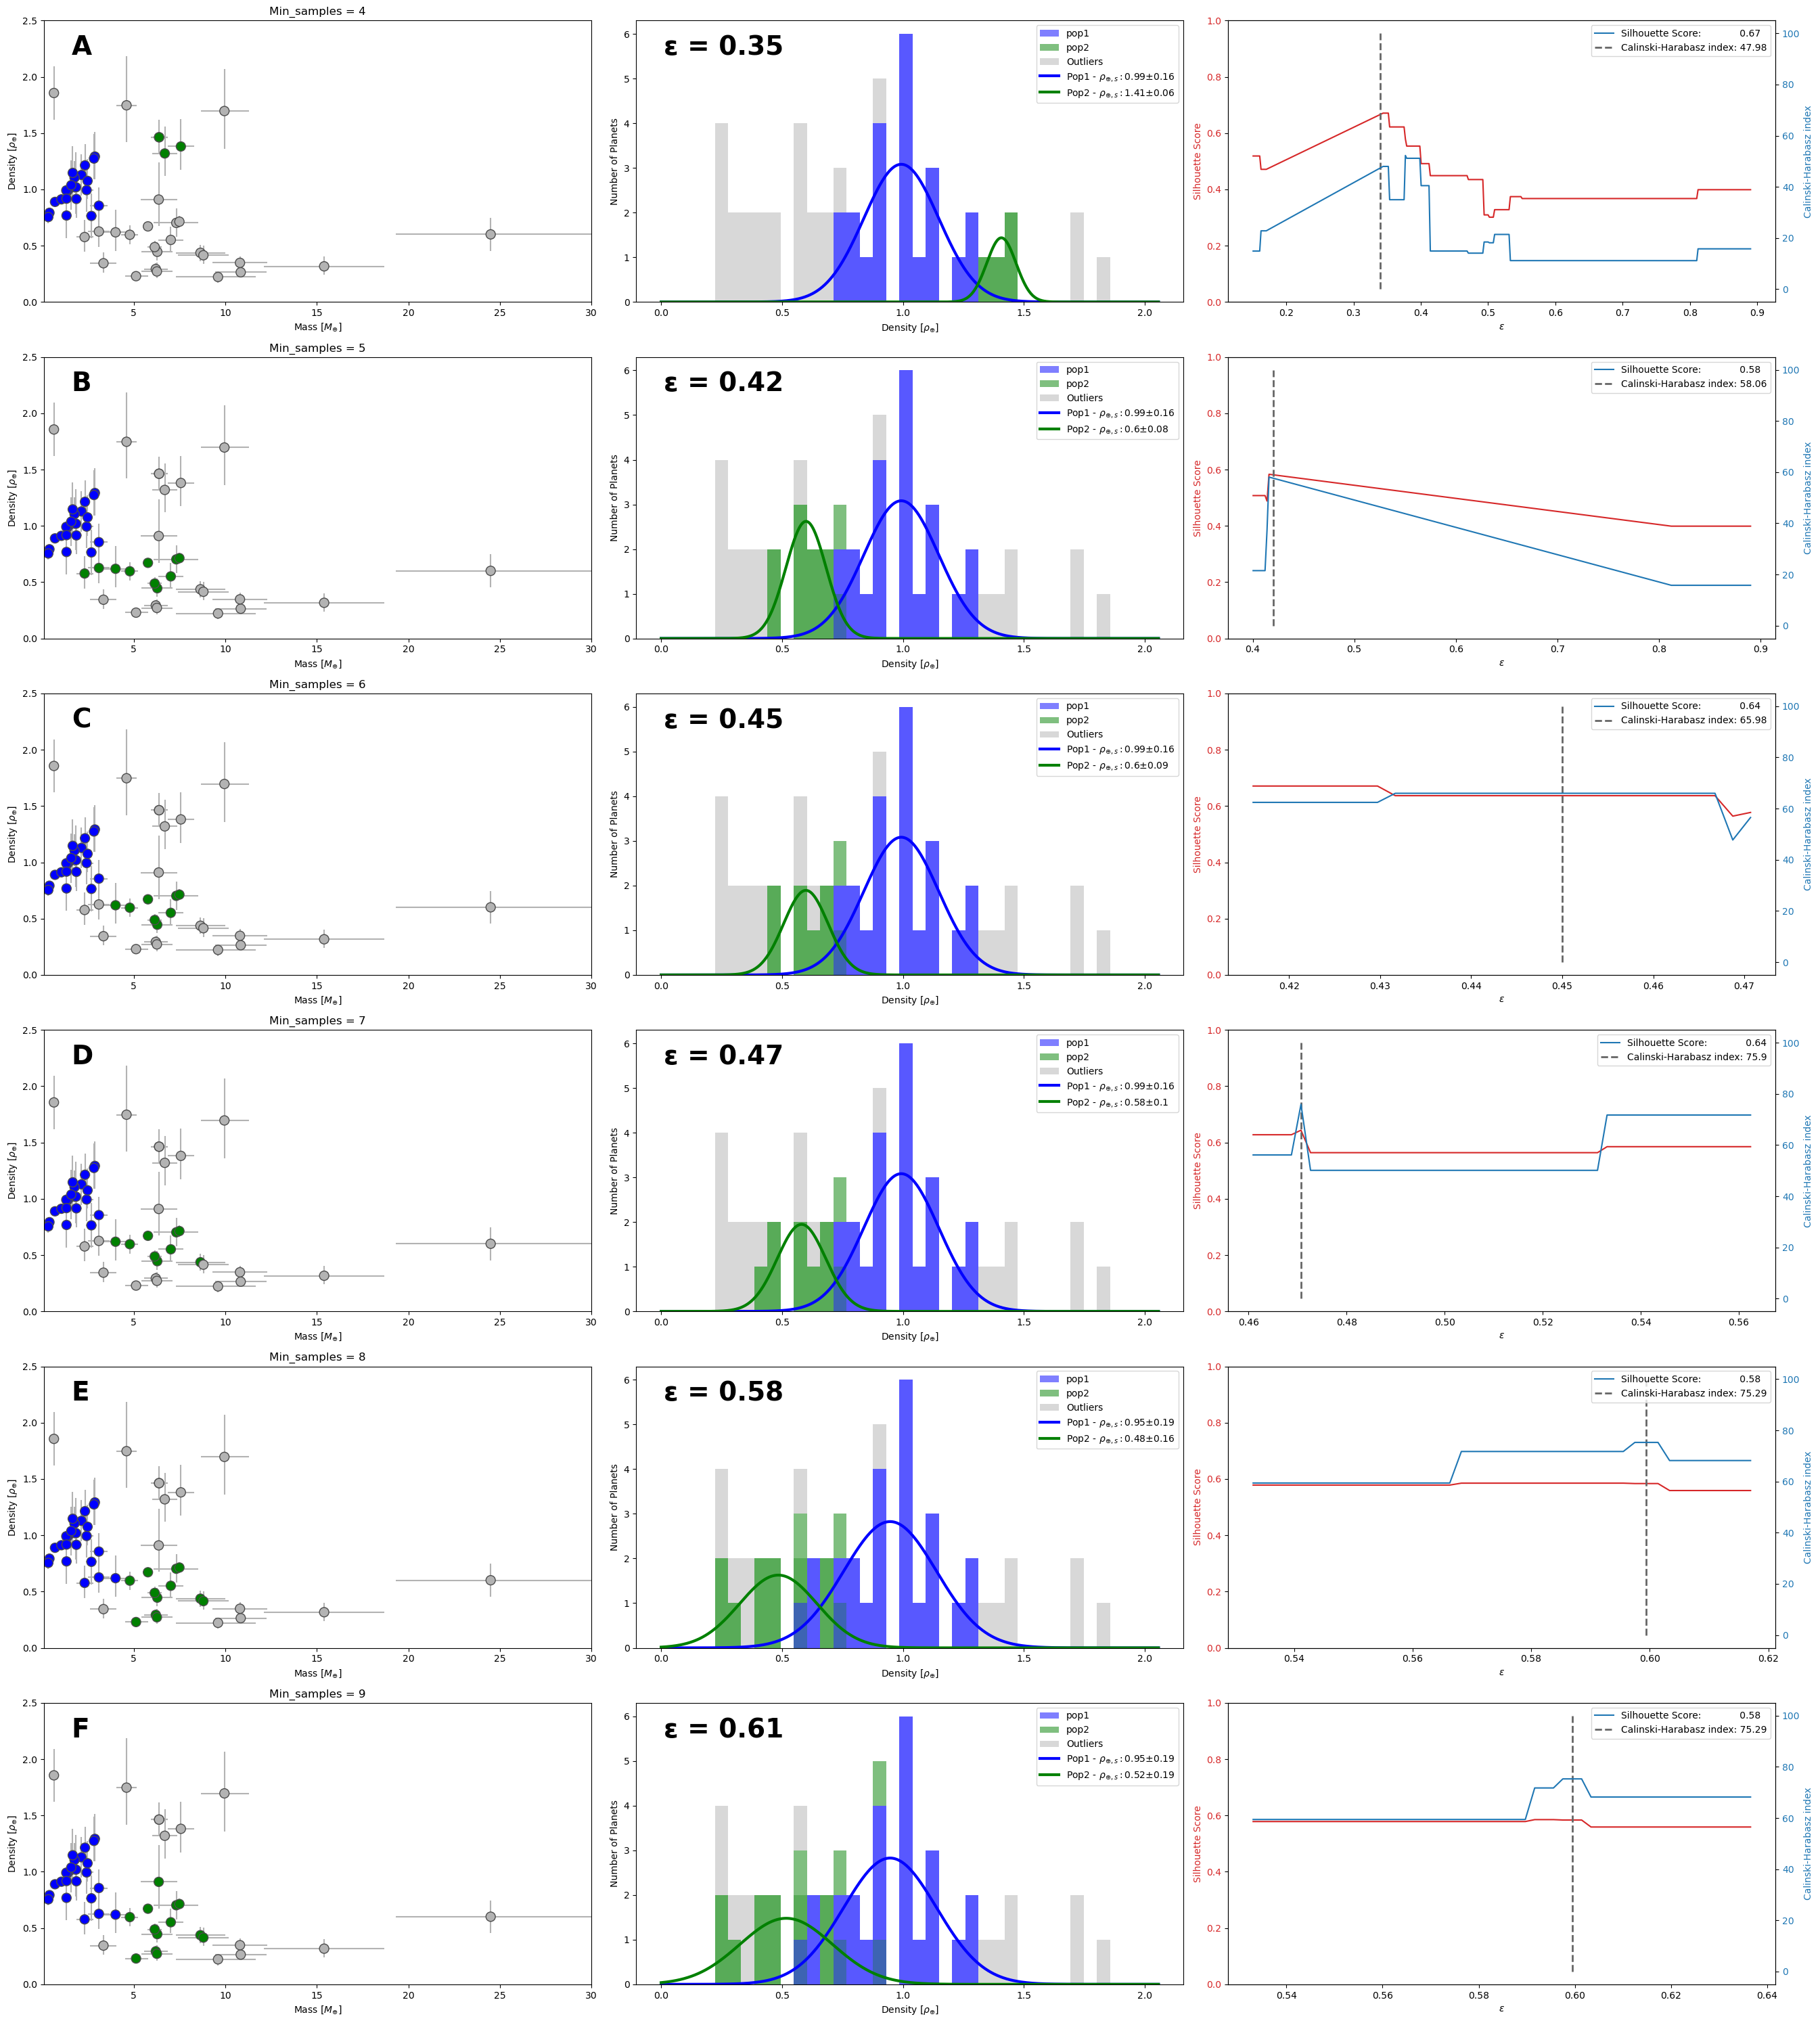

In [244]:
def colorlist(labels):
    color=["0.7",'blue', 'green']
    colors = []
    for i in range(len(labels)):
        if labels[i] == -1:
            colors.append(color[0])
        if labels[i] == 0:
            colors.append(color[1])
        if labels[i] == 1:
            colors.append(color[2])
    return colors
df = pd.DataFrame({'Mass': mass, 'Density': density/earth_density})
esps = np.linspace(0.1,4, 2000)
fig, ax = plt.subplots(figsize=(27,30))
for i, label in enumerate(('A',"ε = 0.35", "", 'B',"ε = 0.42","", "C","ε = 0.45","","D","ε = 0.47","","E","ε = 0.58","","F","ε = 0.61","")):
    ax = fig.add_subplot(6,3,i+1)
    ax.text(0.05, 0.95, label, transform=ax.transAxes,
      fontsize=28, fontweight='bold', va='top')
    
                ###############################  MIN_SAMPLE = 4 ###############################33
ax = plt.subplot(6, 3, 1)
plt.title("Min_samples = 4")
dbscan = DBSCAN(eps=0.35, min_samples=4,metric = "euclidean")
dbscan.fit(scaled_data)
clusters = dbscan.fit_predict(pca_result)
clusters4 = clusters
colors = colorlist(clusters)
plt.errorbar(mass,density/earth_density,xerr = mass_error,yerr = density_error/earth_density,fmt = ".",color = "0.7",zorder = -40)
ax.scatter(mass, density/earth_density, c=colors, s=100, edgecolor="0.3")
ax.set_xlim(0.1, 30)
ax.set_ylim(0,2.5)
ax.set_xlabel("Mass $[M_{\oplus}]$")
ax.set_ylabel("Density $[ρ_{\oplus}]$")

pop1 = [(density/earth_density)[i] for i in range(len(clusters)) if clusters[i] == 0]
pop2 = [(density/earth_density)[i] for i in range(len(clusters)) if clusters[i] == 1]
pop3 = [(density/earth_density)[i] for i in range(len(clusters)) if clusters[i] == -1]
ax = plt.subplot(6, 3, 2)
bins = 30
range_min = min(min(pop1), min(pop2), min(pop3))
range_max = max(max(pop1), max(pop2), max(pop3))
hbins  = np.linspace(0, range_max + 0.2, 1000)
ax.hist([pop1, pop2, pop3], bins=bins, range=(range_min, range_max), alpha=0.5, label=['pop1', 'pop2', 'Outliers'], color=['blue', 'green', "0.7"], stacked=True)
hist_values_false, bin_edges, _ = ax.hist(pop1, bins=bins,range=(range_min, range_max), color='Blue', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop1)
sigma = np.sqrt(np.cov(pop1, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Blue",linewidth=3,label ="Pop1 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

hist_values_false, bin_edges, _ = ax.hist(pop2, bins=bins,range=(range_min, range_max), color='Green', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop2)
sigma = np.sqrt(np.cov(pop2, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Green",linewidth=3,label ="Pop2 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))
plt.legend()
ax.set_xlabel("Density $[ρ_{\oplus}]$")
ax.set_ylabel("Number of Planets")

epsilons = []
silhouette_avg = []
calinski_harabasz_index = []

ax = plt.subplot(6, 3, 3)
for i in range(0,len(esps)):
    dbscan = DBSCAN(eps=esps[i], min_samples=4,metric = "euclidean")
    dbscan.fit(pca_result)
    clusters = dbscan.fit_predict(pca_result)
    if 1 in clusters:
        silhouette_avg.append(silhouette_score(pca_result[clusters != -1], clusters[clusters != -1]))
        calinski_harabasz_index.append(calinski_harabasz_score(pca_result[clusters != -1], clusters[clusters != -1]))
        epsilons.append(esps[i]) 

ax1 = ax
ax2 = ax.twinx()
color = 'tab:red'
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(epsilons, silhouette_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1])

color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz index', color=color)
ax2.plot(epsilons, calinski_harabasz_index, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.yticks([0,20,40,60,80,100])

max_value = max(silhouette_avg)
max_index = silhouette_avg.index(max_value)

fig.tight_layout()
plt.vlines(np.round(epsilons[max_index],2),0,100,colors = "0.4",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.legend(["Silhouette Score:             " + str(np.round(silhouette_avg[max_index],2)),"Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[max_index],2))])
#print("DBSCAN: min_samples = 4, ε = "+str(np.round(epsilons[max_index],2)))
#print("Silhouette Score:        " + str(np.round(silhouette_avg[max_index],2)))
#print("Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[max_index],2)))
#print("")

                ###############################  MIN_SAMPLE = 5 ###############################
ax = plt.subplot(6, 3, 4)
plt.title("Min_samples = 5")
dbscan = DBSCAN(eps=0.4160580290145073, min_samples=5,metric = "euclidean")
dbscan.fit(scaled_data)
clusters = dbscan.fit_predict(pca_result)
clusters5 = clusters
colors = colorlist(clusters)
plt.errorbar(mass,density/earth_density,xerr = mass_error,yerr = density_error/earth_density,fmt = ".",color = "0.7",zorder = -40)
ax.scatter(mass, density/earth_density, c=colors, s=100, edgecolor="0.3")
ax.set_xlim(0.1, 30)
ax.set_ylim(0,2.5)
ax.set_xlabel("Mass $[M_{\oplus}]$")
ax.set_ylabel("Density $[ρ_{\oplus}]$")
pop1 = [(density/earth_density)[i] for i in range(len(clusters)) if clusters[i] == 0]
pop2 = [(density/earth_density)[i] for i in range(len(clusters)) if clusters[i] == 1]
pop3 = [(density/earth_density)[i] for i in range(len(clusters)) if clusters[i] == -1]
ax = plt.subplot(6, 3, 5)
bins = 30
range_min = min(min(pop1), min(pop2), min(pop3))
range_max = max(max(pop1), max(pop2), max(pop3))
ax.hist([pop1, pop2, pop3], bins=bins, range=(range_min, range_max), alpha=0.5, label=['pop1', 'pop2', 'Outliers'], color=['blue', 'green', "0.7"], stacked=True)
hist_values_false, bin_edges, _ = ax.hist(pop1, bins=bins,range=(range_min, range_max), color='Blue', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop1)
sigma = np.sqrt(np.cov(pop1, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Blue",linewidth=3,label ="Pop1 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

hist_values_false, bin_edges, _ = ax.hist(pop2, bins=bins,range=(range_min, range_max), color='Green', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop2)
sigma = np.sqrt(np.cov(pop2, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Green",linewidth=3,label ="Pop2 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))
plt.legend()
ax.set_xlabel("Density $[ρ_{\oplus}]$")
ax.set_ylabel("Number of Planets")

ax = plt.subplot(6, 3, 6)
epsilons = []
silhouette_avg = []
calinski_harabasz_index = []

for i in range(0,len(esps)):
    dbscan = DBSCAN(eps=esps[i], min_samples=5,metric = "euclidean")
    dbscan.fit(pca_result)
    clusters = dbscan.fit_predict(pca_result)
    if 1 in clusters:
        silhouette_avg.append(silhouette_score(pca_result[clusters != -1], clusters[clusters != -1]))
        calinski_harabasz_index.append(calinski_harabasz_score(pca_result[clusters != -1], clusters[clusters != -1]))
        epsilons.append(esps[i])
        
ax1 = ax
ax2 = ax.twinx()
color = 'tab:red'
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(epsilons, silhouette_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1])

color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz index', color=color)
ax2.plot(epsilons, calinski_harabasz_index, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.yticks([0,20,40,60,80,100])

max_value = max(silhouette_avg)
max_index = silhouette_avg.index(max_value)

fig.tight_layout()
plt.vlines(np.round(epsilons[max_index],2),0,100,colors = "0.4",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.legend(["Silhouette Score:             " + str(np.round(silhouette_avg[max_index],2)),"Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[max_index],2))])
#print("DBSCAN: min_samples = 5, ε = "+str(np.round(epsilons[max_index],2)))
#print("Silhouette Score:        " + str(np.round(silhouette_avg[max_index],2)))
#print("Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[max_index],2)))
#print("")

                ###############################  MIN_SAMPLE = 6 ###############################
ax = plt.subplot(6, 3, 7)
plt.title("Min_samples = 6")
dbscan = DBSCAN(eps=0.45, min_samples=6,metric = "euclidean")
dbscan.fit(scaled_data)
clusters = dbscan.fit_predict(pca_result)
clusters6 = clusters
colors = colorlist(clusters)
plt.errorbar(mass,density/earth_density,xerr = mass_error,yerr = density_error/earth_density,fmt = ".",color = "0.7",zorder = -40)
ax.scatter(mass, density/earth_density, c=colors, s=100, edgecolor="0.3")
ax.set_xlim(0.1, 30)
ax.set_ylim(0,2.5)
ax.set_xlabel("Mass $[M_{\oplus}]$")
ax.set_ylabel("Density $[ρ_{\oplus}]$")

pop1 = [(density/earth_density)[i] for i in range(len(clusters)) if clusters[i] == 0]
pop2 = [(density/earth_density)[i] for i in range(len(clusters)) if clusters[i] == 1]
pop3 = [(density/earth_density)[i] for i in range(len(clusters)) if clusters[i] == -1]
ax = plt.subplot(6, 3, 8)
bins = 30
range_min = min(min(pop1), min(pop2), min(pop3))
range_max = max(max(pop1), max(pop2), max(pop3))
ax.hist([pop1, pop2, pop3], bins=bins, range=(range_min, range_max), alpha=0.5, label=['pop1', 'pop2', 'Outliers'], color=['blue', 'green', "0.7"], stacked=True)
hist_values_false, bin_edges, _ = ax.hist(pop1, bins=bins,range=(range_min, range_max), color='Blue', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop1)
sigma = np.sqrt(np.cov(pop1, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Blue",linewidth=3,label ="Pop1 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

hist_values_false, bin_edges, _ = ax.hist(pop2, bins=bins,range=(range_min, range_max), color='Green', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop2)
sigma = np.sqrt(np.cov(pop2, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Green",linewidth=3,label ="Pop2 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))
plt.legend()
ax.set_xlabel("Density $[ρ_{\oplus}]$")
ax.set_ylabel("Number of Planets")


ax = plt.subplot(6, 3, 9)
epsilons = []
silhouette_avg = []
calinski_harabasz_index = []

for i in range(0,len(esps)):
    dbscan = DBSCAN(eps=esps[i], min_samples=6,metric = "euclidean")
    dbscan.fit(pca_result)
    clusters = dbscan.fit_predict(pca_result)
    if 1 in clusters:
        silhouette_avg.append(silhouette_score(pca_result[clusters != -1], clusters[clusters != -1]))
        calinski_harabasz_index.append(calinski_harabasz_score(pca_result[clusters != -1], clusters[clusters != -1]))
        epsilons.append(esps[i])
        
ax1 = ax
ax2 = ax.twinx()
color = 'tab:red'
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(epsilons, silhouette_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1])

color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz index', color=color)
ax2.plot(epsilons, calinski_harabasz_index, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.yticks([0,20,40,60,80,100])

max_value = max(calinski_harabasz_index)
max_index = calinski_harabasz_index.index(max_value)+8

fig.tight_layout()
plt.vlines(np.round(epsilons[max_index],2),0,100,colors = "0.4",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.legend(["Silhouette Score:             " + str(np.round(silhouette_avg[max_index],2)),"Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[max_index],2))])
#print("DBSCAN: min_samples = 6, ε = "+str(np.round(epsilons[max_index],2)))
#print("Silhouette Score:        " + str(np.round(silhouette_avg[max_index],2)))
#print("Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[max_index],2)))
#print("")


                ###############################  MIN_SAMPLE = 7 ###############################
ax = plt.subplot(6, 3, 10)
plt.title("Min_samples = 7")
dbscan = DBSCAN(eps=0.47068534267133566, min_samples=7,metric = "euclidean")
dbscan.fit(scaled_data)
clusters = dbscan.fit_predict(pca_result)
clusters7 = clusters
colors = colorlist(clusters)
plt.errorbar(mass,density/earth_density,xerr = mass_error,yerr = density_error/earth_density,fmt = ".",color = "0.7",zorder = -40)
ax.scatter(mass, density/earth_density, c=colors, s=100, edgecolor="0.3")
ax.set_xlim(0.1, 30)
ax.set_ylim(0,2.5)
ax.set_xlabel("Mass $[M_{\oplus}]$")
ax.set_ylabel("Density $[ρ_{\oplus}]$")
pop1 = [(density/earth_density)[i] for i in range(len(clusters)) if clusters[i] == 0]
pop2 = [(density/earth_density)[i] for i in range(len(clusters)) if clusters[i] == 1]
pop3 = [(density/earth_density)[i] for i in range(len(clusters)) if clusters[i] == -1]
ax = plt.subplot(6, 3, 11)
bins = 30
range_min = min(min(pop1), min(pop2), min(pop3))
range_max = max(max(pop1), max(pop2), max(pop3))
ax.hist([pop1, pop2, pop3], bins=bins, range=(range_min, range_max), alpha=0.5, label=['pop1', 'pop2', 'Outliers'], color=['blue', 'green', "0.7"], stacked=True)
hist_values_false, bin_edges, _ = ax.hist(pop1, bins=bins,range=(range_min, range_max), color='Blue', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop1)
sigma = np.sqrt(np.cov(pop1, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Blue",linewidth=3,label ="Pop1 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

hist_values_false, bin_edges, _ = ax.hist(pop2, bins=bins,range=(range_min, range_max), color='Green', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop2)
sigma = np.sqrt(np.cov(pop2, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Green",linewidth=3,label ="Pop2 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))
plt.legend()
ax.set_xlabel("Density $[ρ_{\oplus}]$")
ax.set_ylabel("Number of Planets")

ax = plt.subplot(6, 3, 12)
epsilons = []
silhouette_avg = []
calinski_harabasz_index = []

for i in range(0,len(esps)):
    dbscan = DBSCAN(eps=esps[i], min_samples=7,metric = "euclidean")
    dbscan.fit(pca_result)
    clusters = dbscan.fit_predict(pca_result)
    if 1 in clusters:
        silhouette_avg.append(silhouette_score(pca_result[clusters != -1], clusters[clusters != -1]))
        calinski_harabasz_index.append(calinski_harabasz_score(pca_result[clusters != -1], clusters[clusters != -1]))
        epsilons.append(esps[i])
        
ax1 = ax
ax2 = ax.twinx()
color = 'tab:red'
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(epsilons, silhouette_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1])

color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz index', color=color)
ax2.plot(epsilons, calinski_harabasz_index, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.yticks([0,20,40,60,80,100])

max_value = max(calinski_harabasz_index)
max_index = calinski_harabasz_index.index(max_value)

fig.tight_layout()
plt.vlines(epsilons[max_index],0,100,colors = "0.4",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.legend(["Silhouette Score:             " + str(np.round(silhouette_avg[max_index],2)),"Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[max_index],2))])

#print("DBSCAN: min_samples = 7, ε = "+str(np.round(epsilons[4],2)))
#print("Silhouette Score:        " + str(np.round(silhouette_avg[4],2)))
#print("Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[4],2)))
#print("")


                ###############################  MIN_SAMPLE = 8 ###############################

ax = plt.subplot(6, 3, 13)
plt.title("Min_samples = 8")
dbscan = DBSCAN(eps=0.599, min_samples=8,metric = "euclidean")
dbscan.fit(scaled_data)
clusters = dbscan.fit_predict(pca_result)
clusters8 = clusters
colors = colorlist(clusters)
plt.errorbar(mass,density/earth_density,xerr = mass_error,yerr = density_error/earth_density,fmt = ".",color = "0.7",zorder = -40)
ax.scatter(mass, density/earth_density, c=colors, s=100, edgecolor="0.3")
ax.set_xlim(0.1, 30)
ax.set_ylim(0,2.5)
ax.set_xlabel("Mass $[M_{\oplus}]$")
ax.set_ylabel("Density $[ρ_{\oplus}]$")
pop1 = [(density/earth_density)[i] for i in range(len(clusters)) if clusters[i] == 0]
pop2 = [(density/earth_density)[i] for i in range(len(clusters)) if clusters[i] == 1]
pop3 = [(density/earth_density)[i] for i in range(len(clusters)) if clusters[i] == -1]
ax = plt.subplot(6, 3, 14)
bins = 30
range_min = min(min(pop1), min(pop2), min(pop3))
range_max = max(max(pop1), max(pop2), max(pop3))
ax.hist([pop1, pop2, pop3], bins=bins, range=(range_min, range_max), alpha=0.5, label=['pop1', 'pop2', 'Outliers'], color=['blue', 'green', "0.7"], stacked=True)
hist_values_false, bin_edges, _ = ax.hist(pop1, bins=bins,range=(range_min, range_max), color='Blue', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop1)
sigma = np.sqrt(np.cov(pop1, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Blue",linewidth=3,label ="Pop1 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

hist_values_false, bin_edges, _ = ax.hist(pop2, bins=bins,range=(range_min, range_max), color='Green', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop2)
sigma = np.sqrt(np.cov(pop2, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Green",linewidth=3,label ="Pop2 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))
plt.legend()
ax.set_xlabel("Density $[ρ_{\oplus}]$")
ax.set_ylabel("Number of Planets")

ax = plt.subplot(6, 3, 15)
epsilons = []
silhouette_avg = []
calinski_harabasz_index = []

for i in range(0,len(esps)):
    dbscan = DBSCAN(eps=esps[i], min_samples=8,metric = "euclidean")
    dbscan.fit(pca_result)
    clusters = dbscan.fit_predict(pca_result)
    if 1 in clusters:
        silhouette_avg.append(silhouette_score(pca_result[clusters != -1], clusters[clusters != -1]))
        calinski_harabasz_index.append(calinski_harabasz_score(pca_result[clusters != -1], clusters[clusters != -1]))
        epsilons.append(esps[i])
        
ax1 = ax
ax2 = ax.twinx()
color = 'tab:red'
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(epsilons, silhouette_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1])

color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz index', color=color)
ax2.plot(epsilons, calinski_harabasz_index, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.yticks([0,20,40,60,80,100])

max_value = max(calinski_harabasz_index)
max_index = calinski_harabasz_index.index(max_value)+1

fig.tight_layout()
plt.vlines(epsilons[max_index],0,100,colors = "0.4",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.legend(["Silhouette Score:             " + str(np.round(silhouette_avg[max_index],2)),"Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[max_index],2))])

                ###############################  MIN_SAMPLE = 9 ###############################
ax = plt.subplot(6, 3, 16)
plt.title("Min_samples = 9")
dbscan = DBSCAN(eps=0.61, min_samples=9,metric = "euclidean")
dbscan.fit(scaled_data)
clusters = dbscan.fit_predict(pca_result)
colors = colorlist(clusters)
clusters9 = clusters
plt.errorbar(mass,density/earth_density,xerr = mass_error,yerr = density_error/earth_density,fmt = ".",color = "0.7",zorder = -40)
ax.scatter(mass, density/earth_density, c=colors, s=100, edgecolor="0.3")
ax.set_xlim(0.1, 30)
ax.set_ylim(0,2.5)
ax.set_xlabel("Mass $[M_{\oplus}]$")
ax.set_ylabel("Density $[ρ_{\oplus}]$")

pop1 = [(density/earth_density)[i] for i in range(len(clusters)) if clusters[i] == 0]
pop2 = [(density/earth_density)[i] for i in range(len(clusters)) if clusters[i] == 1]
pop3 = [(density/earth_density)[i] for i in range(len(clusters)) if clusters[i] == -1]
ax = plt.subplot(6, 3, 17)
bins = 30
range_min = min(min(pop1), min(pop2), min(pop3))
range_max = max(max(pop1), max(pop2), max(pop3))
ax.hist([pop1, pop2, pop3], bins=bins, range=(range_min, range_max), alpha=0.5, label=['pop1', 'pop2', 'Outliers'], color=['blue', 'green', "0.7"], stacked=True)
hist_values_false, bin_edges, _ = ax.hist(pop1, bins=bins,range=(range_min, range_max), color='Blue', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop1)
sigma = np.sqrt(np.cov(pop1, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Blue",linewidth=3,label ="Pop1 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

hist_values_false, bin_edges, _ = ax.hist(pop2, bins=bins,range=(range_min, range_max), color='Green', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop2)
sigma = np.sqrt(np.cov(pop2, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Green",linewidth=3,label ="Pop2 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))
plt.legend()
ax.set_xlabel("Density $[ρ_{\oplus}]$")
ax.set_ylabel("Number of Planets")

ax = plt.subplot(6, 3, 18)
epsilons = []
silhouette_avg = []
calinski_harabasz_index = []

for i in range(0,len(esps)):
    dbscan = DBSCAN(eps=esps[i], min_samples=9,metric = "euclidean")
    dbscan.fit(pca_result)
    clusters = dbscan.fit_predict(pca_result)
    if 1 in clusters:
        silhouette_avg.append(silhouette_score(pca_result[clusters != -1], clusters[clusters != -1]))
        calinski_harabasz_index.append(calinski_harabasz_score(pca_result[clusters != -1], clusters[clusters != -1]))
        epsilons.append(esps[i])
        
ax1 = ax
ax2 = ax.twinx()
color = 'tab:red'
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(epsilons, silhouette_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1])


color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz index', color=color)
ax2.plot(epsilons, calinski_harabasz_index, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.yticks([0,20,40,60,80,100])

max_value = max(calinski_harabasz_index)
max_index = calinski_harabasz_index.index(max_value)+1

fig.tight_layout()
plt.vlines(epsilons[max_index],0,100,colors = "0.4",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.legend(["Silhouette Score:             " + str(np.round(silhouette_avg[max_index],2)),"Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[max_index],2))])

image_name = 'DBSCAN_full.jpeg'
image_format = 'jpeg'
fig.savefig(image_name, format=image_format, dpi=800)

Text(0, 0.5, 'Density $[ρ_{\\oplus}]$')

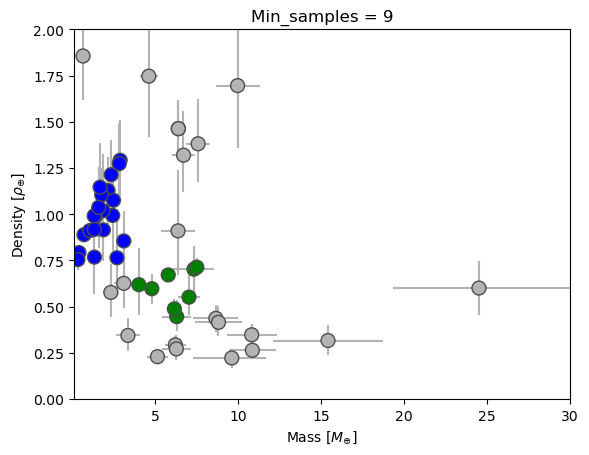

In [243]:
ax = plt.subplot(1, 1, 1)
plt.title("Min_samples = 9")
dbscan = DBSCAN(eps=0.46,min_samples = 6,metric = "euclidean")
dbscan.fit(scaled_data)
clusters = dbscan.fit_predict(pca_result)
colors = colorlist(clusters)
clusters9 = clusters
plt.errorbar(mass,density/earth_density,xerr = mass_error,yerr = density_error/earth_density,fmt = ".",color = "0.7",zorder = -40)
ax.scatter(mass, density/earth_density, c=colors, s=100, edgecolor="0.3")

ax.set_xlim(0.1, 30)
ax.set_ylim(0,2)
ax.set_xlabel("Mass $[M_{\oplus}]$")
ax.set_ylabel("Density $[ρ_{\oplus}]$")

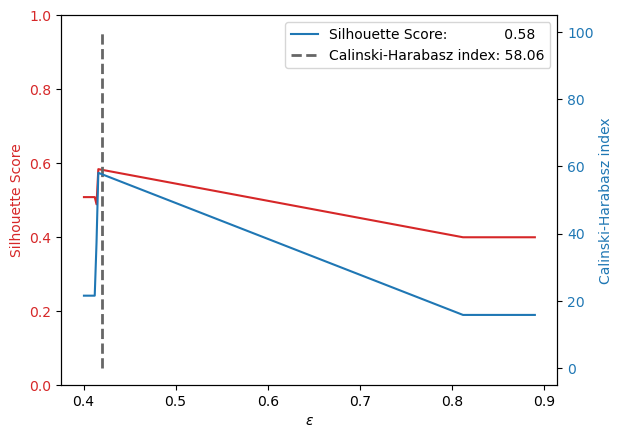

In [230]:
epsilons = []
silhouette_avg = []
calinski_harabasz_index = []
ax = plt.subplot(1, 1, 1)

for i in range(0,len(esps)):
    dbscan = DBSCAN(eps=esps[i], min_samples=6,metric = "euclidean")
    dbscan.fit(pca_result)
    clusters = dbscan.fit_predict(pca_result)
    if 1 in clusters:
        silhouette_avg.append(silhouette_score(pca_result[clusters != -1], clusters[clusters != -1]))
        calinski_harabasz_index.append(calinski_harabasz_score(pca_result[clusters != -1], clusters[clusters != -1]))
        epsilons.append(esps[i])
        
ax1 = ax
ax2 = ax.twinx()
color = 'tab:red'
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(epsilons, silhouette_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1])

color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz index', color=color)
ax2.plot(epsilons, calinski_harabasz_index, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.yticks([0,20,40,60,80,100])

max_value = max(silhouette_avg)
max_index = silhouette_avg.index(max_value)

fig.tight_layout()
plt.vlines(np.round(epsilons[max_index],2),0,100,colors = "0.4",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.legend(["Silhouette Score:             " + str(np.round(silhouette_avg[max_index],2)),"Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[max_index],2))])
#print("DBSCAN: min_samples = 5, ε = "+str(np.round(epsilons[max_index],2)))
#print("Silhouette Score:        " + str(np.round(silhouette_avg[max_index],2)))
#print("Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[max_index],2)))
#print("")